In [6]:
import pandas as pd
import numpy as np
import re  
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding

In [7]:
data = pd.read_csv('swiggy.csv')
print("Columns in the dataset:")
print(data.columns.tolist())
data.head()

Columns in the dataset:
['ID', 'Area', 'City', 'Restaurant Price', 'Avg Rating', 'Total Rating', 'Food Item', 'Food Type', 'Delivery Time', 'Review']


,ID,Area,City,Restaurant Price,Avg Rating,Total Rating,Food Item,Food Type,Delivery Time,Review
0,1,Suburb,Ahmedabad,600,4.2,6198,Sushi,Fast Food,30-40 min,"Good, but nothing extraordinary."
1,2,Business District,Pune,200,4.7,4865,Pepperoni Pizza,Non-Vegetarian,50-60 min,"Good, but nothing extraordinary."
2,3,Suburb,Bangalore,600,4.7,2095,Waffles,Fast Food,50-60 min,Late delivery ruined it.
3,4,Business District,Mumbai,900,4.0,6639,Sushi,Vegetarian,50-60 min,Best meal I've had in a while!
4,5,Tech Park,Mumbai,200,4.7,6926,Spring Rolls,Gluten-Free,20-30 min,Mediocre experience.


In [8]:
data["Review"] = data["Review"].str.lower()
data["Review"] = data["Review"].replace(r'[^a-z0-9\s]', '', regex=True)

data['sentiment'] = data['Avg Rating'].apply(lambda x: 1 if x > 3.5 else 0)
data = data.dropna() 


In [9]:
max_features = 5000   
max_length = 200   

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data["Review"]) /builds the word index reviews in dataset
X = pad_sequences(tokenizer.texts_to_sequences(data["Review"]), maxlen=max_length)
y = data['sentiment'].values  /model training


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)


In [11]:
model = Sequential([
    Embedding(input_dim=max_features, output_dim=16),
    SimpleRNN(64, activation='tanh', return_sequences=False),                   
    Dense(1, activation='sigmoid')                                          
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [12]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {score[1]:.2f}")


Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7092 - loss: 0.6075 - val_accuracy: 0.7156 - val_loss: 0.5996
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7103 - loss: 0.6043 - val_accuracy: 0.7156 - val_loss: 0.6021
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7192 - loss: 0.5958 - val_accuracy: 0.7156 - val_loss: 0.5962
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7144 - loss: 0.5985 - val_accuracy: 0.7156 - val_loss: 0.5991
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7128 - loss: 0.5980 - val_accuracy: 0.7156 - val_loss: 0.5980
Test accuracy: 0.72


In [14]:
def predict_sentiment(review_text):
    text = review_text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_length)

    prediction = model.predict(padded)[0][0]
    return f"{'Positive' if prediction >= 0.5 else 'Negative'} (Probability: {prediction:.2f})"
    
sample_review = "the food was goood"
print(f"Review: {sample_review}")
print(f"Sentiment: {predict_sentiment(sample_review)}")


Review: the food was goood
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
Sentiment: Positive (Probability: 0.71)


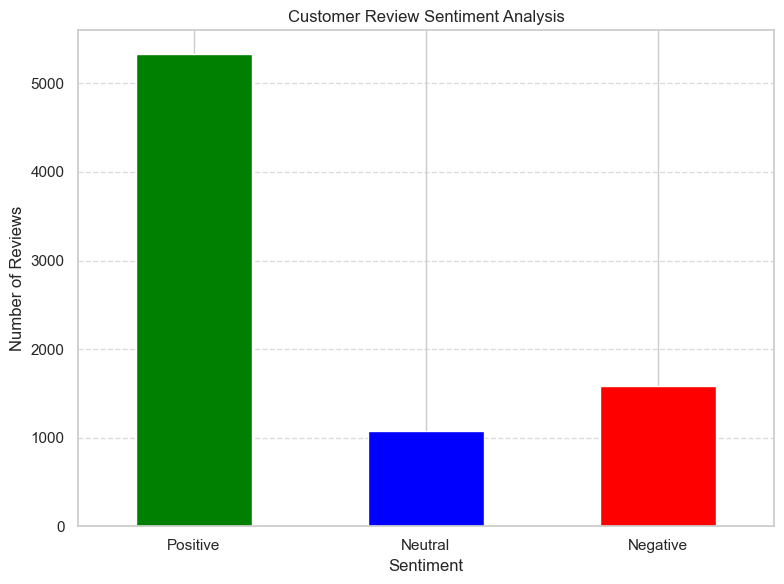

In [19]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

def classify_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'


data['Sentiment'] = data['Review'].apply(classify_sentiment)


sentiment_counts = data['Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative'], fill_value=0)


plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Customer Review Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


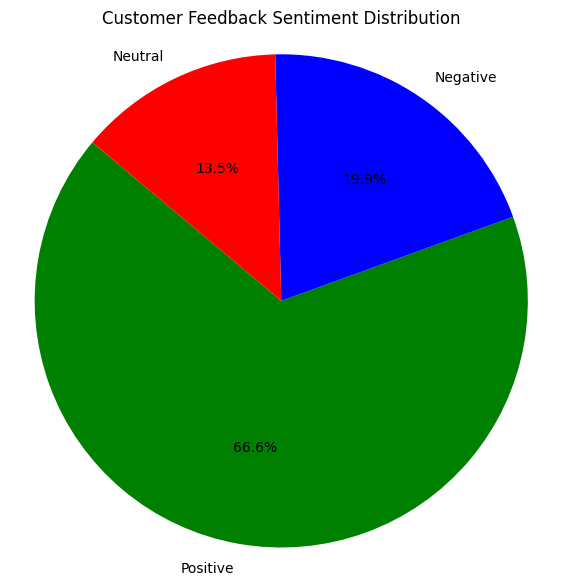

In [16]:
 data['Sentiment'] = data['Review'].apply(classify_sentiment)

# Step 2: Count sentiment types
sentiment_counts = data['Sentiment'].value_counts()

# Step 3: Create Pie Chart
plt.figure(figsize=(7, 7))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['green', 'blue', 'red']
)
plt.title('Customer Feedback Sentiment Distribution')
plt.axis('equal')  # Makes the pie chart a circle
plt.show()

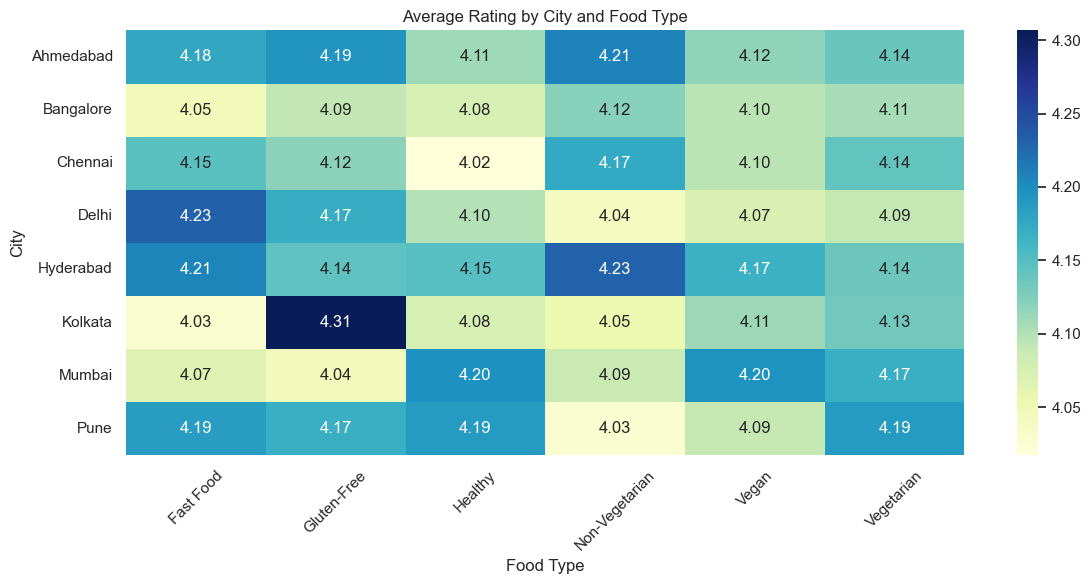

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

 
pivot_table = data.pivot_table(
    values='Avg Rating',
    index='City',
    columns='Food Type',
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Rating by City and Food Type")
plt.ylabel("City")
plt.xlabel("Food Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
